In [ ]:
!pip install easyocr ultralytics
import os
import easyocr
from ultralytics import YOLO
import cv2
import numpy as np
import re
import pandas as pd
from datetime import datetime, timedelta
import csv # Added import for csv module

In [16]:
os.environ["KAGGLE_API_TOKEN"] = "KGAT_217bc86399661a10f56435977bcbf87a"

In [17]:
import json

kaggle_creds = {
    "username": "iroonman",
    "key": "KGAT_217bc86399661a10f56435977bcbf87a"
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)

os.chmod("/root/.kaggle/kaggle.json", 600)

print("kaggle.json created successfully")


kaggle.json created successfully


In [ ]:
!kaggle datasets download -d andrewmvd/car-plate-detection
!unzip car-plate-detection.zip

In [76]:
import xml.etree.ElementTree as ET
from shutil import copyfile
from sklearn.model_selection import train_test_split

IMG_DIR = "images"
ANN_DIR = "annotations"
OUT_DIR = "dataset"

for split in ["train", "val"]:
    os.makedirs(f"{OUT_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUT_DIR}/labels/{split}", exist_ok=True)

classes = ["car", "licence"]

def convert_bbox(size, box):
    w, h = size
    xmin, xmax, ymin, ymax = box
    x_center = (xmin + xmax) / 2.0 / w
    y_center = (ymin + ymax) / 2.0 / h
    bw = (xmax - xmin) / w
    bh = (ymax - ymin) / h
    return x_center, y_center, bw, bh

xml_files = sorted(os.listdir(ANN_DIR))
train_files, val_files = train_test_split(xml_files, test_size=0.2, random_state=42)

def process(files, split):
    for xml_file in files:
        tree = ET.parse(os.path.join(ANN_DIR, xml_file))
        root = tree.getroot()

        img_name = root.find("filename").text
        img_path = os.path.join(IMG_DIR, img_name)

        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        label_path = os.path.join(OUT_DIR, "labels", split, img_name.replace(".png", ".txt"))

        with open(label_path, "w") as f:
            for obj in root.findall("object"):
                cls = obj.find("name").text
                cls_id = classes.index(cls)

                bbox = obj.find("bndbox")
                xmin = float(bbox.find("xmin").text)
                ymin = float(bbox.find("ymin").text)
                xmax = float(bbox.find("xmax").text)
                ymax = float(bbox.find("ymax").text)

                bb = convert_bbox((w, h), (xmin, xmax, ymin, ymax))
                f.write(f"{cls_id} {' '.join(map(str, bb))}\n")

        copyfile(img_path, os.path.join(OUT_DIR, "images", split, img_name))

process(train_files, "train")
process(val_files, "val")

print("✅ Conversion complete")


✅ Conversion complete


In [27]:
%%writefile data.yaml
path: dataset
train: images/train
val: images/val

nc: 2
names: ["car", "licence"]


Writing data.yaml


In [ ]:
MODEL_PATH = "runs/detect/train/weights/best.pt"

if os.path.exists(MODEL_PATH):
    print("Loading trained model...")
    model = YOLO(MODEL_PATH)
else:
    print("Training model...")
    model = YOLO("yolov8n.pt")
    model.train(data="data.yaml", epochs=30, imgsz=640, batch=16)

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")
model.predict(source="images/Cars0.png", conf=0.4, save=True)

In [ ]:
from PIL import Image
Image.open("runs/detect/predict/Cars0.jpg")

In [ ]:
import cv2
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")
results = model("images/Cars0.png", conf=0.4)

img = cv2.imread("images/Cars0.png")

plate_img = None

for r in results:
    for box in r.boxes:
        cls_id = int(box.cls[0])
        cls_name = r.names[cls_id]

        if cls_name == "licence":
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            plate_img = img[y1:y2, x1:x2]

(np.float64(-0.5), np.float64(189.5), np.float64(46.5), np.float64(-0.5))

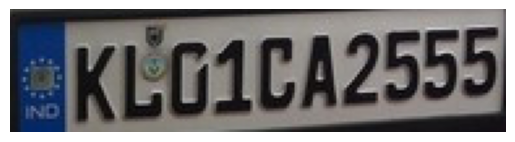

In [79]:
from matplotlib import pyplot as plt

plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

In [ ]:
import cv2
import numpy as np

reader = easyocr.Reader(['en'])

# Convert to grayscale
gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
sharp = cv2.filter2D(gray, -1, kernel)

_, thresh1 = cv2.threshold(sharp, 150, 255, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(sharp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

best_text = ""
best_conf = 0

for img_version in [sharp, thresh1, thresh2]:

    result = reader.readtext(
        img_version,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
        paragraph=False,
        detail=1
    )

    full_text = ""
    confs = []

    for (_, text, prob) in result:
        full_text += text
        confs.append(prob)

    if confs:
        avg_conf = sum(confs) / len(confs)

        if avg_conf > best_conf:
            best_conf = avg_conf
            best_text = full_text

print(f"Plate: {best_text}")
print(f"Confidence: {best_conf}")

In [37]:
import re

text = "INDKLG1CA2555"

pattern = r'[A-Z0-9]+'
match = re.search(pattern, text)

if match:
    print("Final Plate:", match.group())

Final Plate: INDKLG1CA2555


In [ ]:
!pip install ultralytics kaggle kagglehub pyyaml

In [ ]:
import kagglehub

# Download dataset
dataset_path = kagglehub.dataset_download("ashfakyeafi/road-vehicle-images-dataset")
print("Downloaded at:", dataset_path)

In [42]:
trafic_folder = os.path.join(dataset_path, "trafic_data")
print(os.listdir(trafic_folder))

['valid', 'train', 'data_1.yaml']


In [ ]:
with open(os.path.join(trafic_folder, "data_1.yaml")) as f:
    original_data = yaml.safe_load(f)
print(original_data)

In [ ]:
import yaml

yaml_data = {
    'path': '/content/dataset',
    'train': 'images/train',
    'val': 'images/val',
    'nc': 2,
    'names': {
        0: 'two_wheeler',
        1: 'four_wheeler'
    }
}

output_dir = "/content/smart_parking/dataset"
output_file = os.path.join(output_dir, "data.yaml")

# Ensure the directory exists before writing the file
os.makedirs(output_dir, exist_ok=True)

with open(output_file, 'w') as f:
    yaml.dump(yaml_data, f, sort_keys=False)

print(f"data.yaml created successfully at {output_file}")

In [ ]:
model = YOLO("yolov8s.pt")  # pretrained small model

In [50]:
base_path = os.path.join(dataset_path, "trafic_data")
labels_train_source_dir = os.path.join(base_path, "train/labels")
labels_val_source_dir = os.path.join(base_path, "valid/labels")

# Define target output directories for the remapped labels
labels_train_output_dir = "/content/smart_parking/dataset/labels/train"
labels_val_output_dir = "/content/smart_parking/dataset/labels/val"

# Create the output directories if they don't exist
os.makedirs(labels_train_output_dir, exist_ok=True)
os.makedirs(labels_val_output_dir, exist_ok=True)

# Original class names from the downloaded dataset (original_data variable)
original_class_names = original_data['names']

# Define the new class mapping
# New classes: 0: two_wheeler, 1: four_wheeler
new_class_mapping = {
    # Two-wheelers -> New ID 0
    'bicycle': 0,
    'motorbike': 0,
    'scooter': 0,

    # Four-wheelers -> New ID 1
    'ambulance': 1,
    'army vehicle': 1,
    'bus': 1,
    'car': 1,
    'garbagevan': 1,
    'human hauler': 1,
    'minibus': 1,
    'minivan': 1,
    'pickup': 1,
    'policecar': 1,
    'suv': 1,
    'taxi': 1,
    'three wheelers -CNG-': 1,
    'truck': 1,
    'van': 1,
    'auto rickshaw': 1,
    'rickshaw': 1
    # 'wheelbarrow' and any other unmapped classes will be excluded
}

def remap_labels_and_copy(source_dir, output_dir, original_names, new_mapping):
    for filename in os.listdir(source_dir):
        if filename.endswith(".txt"):
            source_filepath = os.path.join(source_dir, filename)
            output_filepath = os.path.join(output_dir, filename)
            new_lines = []
            with open(source_filepath, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 0:
                        original_class_id = int(parts[0])
                        if original_class_id < len(original_names):
                            original_name = original_names[original_class_id]
                            if original_name in new_mapping:
                                new_class_id = new_mapping[original_name]
                                # Replace the original class ID with the new one
                                parts[0] = str(new_class_id)
                                new_lines.append(" ".join(parts))
            # Write the remapped labels to the new writable file
            with open(output_filepath, 'w') as f:
                for line in new_lines:
                    f.write(line + "\n")

print("Remapping and copying labels for training data...")
remap_labels_and_copy(labels_train_source_dir, labels_train_output_dir, original_class_names, new_class_mapping)
print("Remapping and copying labels for validation data...")
remap_labels_and_copy(labels_val_source_dir, labels_val_output_dir, original_class_names, new_class_mapping)
print("Label remapping and copying complete. Starting model training...")

Remapping and copying labels for training data...
Remapping and copying labels for validation data...
Label remapping and copying complete. Starting model training...


In [ ]:
model.train(
    data="/content/smart_parking/dataset/data.yaml",
    epochs=30,       # adjust based on GPU
    imgsz=640,
    batch=16,
    name="smart_parking_model"
)

In [52]:
def get_current_time():
    return datetime.now()

In [53]:
log_file = "parking_log.csv"

if not os.path.exists(log_file):
    with open(log_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["number_plate", "entry_time", "exit_time", "vehicle_type", "fare"])

In [54]:
def process_vehicle(plate_number, vehicle_type, simulated_parked_hours=None):
    now = get_current_time()

    # Read the CSV, explicitly parsing 'entry_time' and 'exit_time' as datetime objects
    df = pd.read_csv("parking_log.csv", parse_dates=["entry_time", "exit_time"])

    # Check if vehicle already inside (exit_time will be NaT for currently parked vehicles)
    existing = df[(df["number_plate"] == plate_number) & (df["exit_time"].isna())]

    if existing.empty:
        # ENTRY
        new_row = {
            "number_plate": plate_number,
            "entry_time": now,
            "exit_time": pd.NaT,  # Use pandas' Not a Time for null exit time
            "vehicle_type": vehicle_type,
            "fare": np.nan # Initialize fare with NaN for numeric consistency
        }
        df.loc[len(df)] = new_row
        print("Vehicle Entry Recorded")

    else:
        # EXIT
        entry_time = existing.iloc[0]["entry_time"]

        if simulated_parked_hours is not None:
            # Calculate exit_time based on simulated parked hours
            exit_time = entry_time + timedelta(hours=simulated_parked_hours)
            duration = simulated_parked_hours # Duration is already in hours
        else:
            # Use current time if no simulation is provided
            exit_time = now
            duration = (exit_time - entry_time).total_seconds() / 3600  # hours

        # Fare calculation
        if vehicle_type == "car": # Assuming 'car' implies four-wheeler for fare calculation
            rate = 20
        elif vehicle_type == "two_wheeler": # Add fare for two-wheelers
            rate = 10
        else:
            rate = 15 # Default rate for unknown types

        fare = round(duration * rate, 2)

        index = existing.index[0]
        df.at[index, "exit_time"] = exit_time  # This assignment is now type-consistent
        df.at[index, "fare"] = fare

        print(f"Vehicle Exit Recorded. Fare: {fare}")

    df.to_csv("parking_log.csv", index=False)

In [65]:
def smart_parking_system(image_path):
    global plate_detection_model, vehicle_classification_model, ocr_reader

    if 'plate_detection_model' not in globals():
        try:
            plate_detection_model = YOLO("runs/detect/train/weights/best.pt")
            print("Initialized plate detection model.")
        except FileNotFoundError:
            print("Error: Plate detection model not found. Please ensure 'plate_detection_model.zip' is uploaded and unzipped.")
            return

    if 'vehicle_classification_model' not in globals():
        try:
            vehicle_classification_model = YOLO("runs/detect/smart_parking_model/weights/best.pt")
            print("Initialized vehicle classification model.")
        except FileNotFoundError:
            print("Error: Vehicle classification model not found. Please ensure 'vehicle_classification_model.zip' is uploaded and unzipped.")
            return

    if 'ocr_reader' not in globals():
        ocr_reader = easyocr.Reader(['en'])
        print("Initialized EasyOCR reader.")

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # 1. Detect license plates
    plate_results = plate_detection_model.predict(source=image_path, conf=0.4, verbose=False)

    detected_plate_img = None
    detected_plate_text = "N/A"

    for r_plate in plate_results:
        for box in r_plate.boxes:
            cls_id = int(box.cls[0])
            cls_name = r_plate.names[cls_id]

            if cls_name == "licence":
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                detected_plate_img = img[y1:y2, x1:x2]
                break
        if detected_plate_img is not None:
            break

    if detected_plate_img is not None:
        # 2. Extract plate number using EasyOCR
        gray = cv2.cvtColor(detected_plate_img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

        kernel = np.array([[0, -1, 0],
                           [-1, 5,-1],
                           [0, -1, 0]])
        sharp = cv2.filter2D(gray, -1, kernel)

        _, thresh1 = cv2.threshold(sharp, 150, 255, cv2.THRESH_BINARY)
        _, thresh2 = cv2.threshold(sharp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        best_text = ""
        best_conf = 0

        for img_version in [sharp, thresh1, thresh2]:
            result = ocr_reader.readtext(
                img_version,
                allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
                paragraph=False,
                detail=1
            )

            full_text = ""
            confs = []

            for (_, text, prob) in result:
                full_text += text
                confs.append(prob)

            if confs:
                avg_conf = sum(confs) / len(confs)
                if avg_conf > best_conf:
                    best_conf = avg_conf
                    best_text = full_text

        pattern = r'[A-Z0-9]+'
        match = re.search(pattern, best_text)
        if match:
            detected_plate_text = match.group()
        print(f"Detected Plate Number: {detected_plate_text} (Confidence: {best_conf:.2f})")

    else:
        print("No license plate detected.")

    # 3. Detect vehicle type (two-wheeler or four-wheeler)
    vehicle_results = vehicle_classification_model.predict(source=image_path, conf=0.25, verbose=False)
    vehicle_type = "Unknown"

    for r_vehicle in vehicle_results:
        for box in r_vehicle.boxes:
            cls_id = int(box.cls[0])
            cls_name = r_vehicle.names[cls_id]

            if cls_name == "two_wheeler":
                vehicle_type = "two_wheeler"
                break
            elif cls_name == "four_wheeler":
                vehicle_type = "four_wheeler"
                break
        if vehicle_type != "Unknown":
            break

    print(f"Detected Vehicle Type: {vehicle_type}")

    # 4. Integrate with parking log
    if detected_plate_text != "N/A" and vehicle_type != "Unknown":
        parked_hours_input = None

        # Check if vehicle is already parked to prompt for exit simulation
        try:
            df = pd.read_csv("parking_log.csv", parse_dates=["entry_time", "exit_time"])
            existing = df[(df["number_plate"] == detected_plate_text) & (df["exit_time"].isna())]
            if not existing.empty:
                while True:
                    try:
                        hours_str = input(f"Vehicle {detected_plate_text} is currently parked. Enter simulated parked hours for exit: ")
                        parked_hours_input = float(hours_str)
                        break
                    except ValueError:
                        print("Invalid input. Please enter a number for hours.")
        except FileNotFoundError:
            pass # parking_log.csv might not exist yet

        process_vehicle(detected_plate_text, vehicle_type, parked_hours_input)
    else:
        print("Cannot log parking event due to missing plate number or vehicle type.")

In [66]:
# Simulate a vehicle entry
smart_parking_system("images/Cars0.png")

Initialized vehicle classification model.
Initialized EasyOCR reader.
Detected Plate Number: INDKLG1CA2555 (Confidence: 0.46)
Detected Vehicle Type: four_wheeler
Vehicle Entry Recorded


In [68]:
from ultralytics import YOLO

plate_model = YOLO("runs/detect/smart_parking_model/weights/best.pt")

In [70]:
vehicle_model = YOLO("runs/detect/smart_parking_model/weights/best.pt")

In [72]:
from ultralytics import YOLO

vehicle_model = YOLO("runs/detect/smart_parking_model/weights/best.pt")

In [77]:
# Simulate a vehicle exit for the same vehicle (you will be prompted for parked hours)
smart_parking_system("images/Cars0.png")

Detected Plate Number: INDKLG1CA2555 (Confidence: 0.46)
Detected Vehicle Type: four_wheeler
Vehicle Entry Recorded


/tmp/ipython-input-4202986227.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df.loc[len(df)] = new_row


In [78]:
df_log = pd.read_csv("parking_log.csv", parse_dates=["entry_time", "exit_time"])
print(df_log)

    number_plate                 entry_time                  exit_time  \
0  INDKLG1CA2555 2026-02-17 20:47:48.384834 2026-02-17 23:47:48.384834   
1  INDKLG1CA2555 2026-02-17 21:35:27.448185                        NaT   

   vehicle_type  fare  
0  four_wheeler  45.0  
1  four_wheeler   NaN  
